## StartUp ML Challenge: On-time arrival data for Airlines
    by MITHU EMILINE JAMES

### Task: 
Build a binary classification model for predicting arrival delays > 15minutes without using departure delay as an input feature.

### Dataset: 
US Dept. of Transportation on-time performance data for non-stop domestic flights
    - Link: https://transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time
    - Data range: [Geography = All of America], [Period = Jan-Apr 2017, May-Jul 2016 and Nov-Dec 2016]

### Approach: 
    1) Load data
    2) Wrangle data: Check for class imbalances and handle it by sampling from the dataset
    3) Wrangle data: Check for sparse columns to remove them
    4) Wrangle data: Check for columns with a few missing values to impute with zero, mean or median
    5) Wrangle data: Encode categorical values to numerical values
    6) Exploratory analyss: Infer distribution of data using histograms
    7) Exploratory analyss: Use measures of central tendency and IQR to understand data at various positions
    8) Variable interdependence: Infer multicollinearity of data through correlation matrix
    9) Feature selection: Remove redundant variables (i.e. columns that refer to the same thing e.g. ID)
    10) Feature engineering: Remove highly collinear variables (i.e. correlation > 0.8)
    11) Feature engineering: Reduce data dimension to the variables that most explain variation in target variable
    12) Modeling building: Random forest is chosen for machine learning modeling
    13) Model comparison: Random forest modeling with original raw data (PART 2) and PCA transformed data (PART 3)
    14) Machine learning process:
        (a) Train/test data: Split data for training and testing
        (b) Model creation: Create models in a grid search for a combination of parameters
        (c) Model selection: Use 10-fold cross validation to evaluate model performance and select the best one
        (c) Final Model training: Use parameters of the best model from above to train on entire train set
        (d) Final Model evaluation: Use 10-fold cross validation for average error on 10 folds of training data
        (e) Final Model performance evaluation: Use confusion matrix, Precision, Recall, ROC to evaluate performance

## PART 1

### Environment set up

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import tabulate
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
get_ipython().magic('matplotlib inline')
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=8)
matplotlib.rc('ytick', labelsize=8)

C:\Users\homeuser\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Set Up

In [2]:
startTime = datetime.now()
folderPath = "C:/Users/homeuser/Documents/MEJ/DS Challenge/StartUpML/Flight Delay/dataFiles"
os.chdir(folderPath)
fdata = pd.DataFrame()
for filename in os.listdir(os.getcwd()):#Reads all data files from above location
    temp = pd.read_csv(filename)
    fdata = fdata.append(temp)

In [3]:
folderPath = "C:/Users/homeuser/Documents/MEJ/DS Challenge/StartUpML/Flight Delay"
os.chdir(folderPath)#Setting working directory
#fileName = "On_Time_On_Time_Performance_2017_1.csv"
#fdata = pd.read_csv(fileName)
#fdata.shape

### Data Wrangling

Target variable is 'ArrDel15' and there was substantial class imbalances as seen below. In order to avoid the classifier learning one class better than the other, sampling was done to even out the class imbalance.

In [4]:
#Handles class imbalance through sampling
classDistribution = fdata['ArrDel15'].value_counts()
print('Class imbalance:')
print(classDistribution)
zero = fdata[fdata['ArrDel15']==0].tail(classDistribution.min())
one = fdata[fdata['ArrDel15']==1]
data = zero.append(one)
del zero, one
data.sort(['Year','Month','DayofMonth','DayOfWeek'], ascending=[False,False,False,False])
#del fdata
print('Class imbalance evened out:')
print(data['ArrDel15'].value_counts())
len(data.columns)

Class imbalance:
0.0    3336085
1.0     794668
Name: ArrDel15, dtype: int64
Class imbalance evened out:
1.0    794668
0.0    794668
Name: ArrDel15, dtype: int64


110

In [5]:
data.head(2)#Showing top 2 rows as sampled data is ordered by time with older data at the top

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
366268,2017,1,2,17,5,2017-02-17,WN,19393,WN,N760SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366269,2017,1,2,17,5,2017-02-17,WN,19393,WN,N944WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.tail(2)#Showing bottom 2 rows as sampled data is ordered by time with latest data at the bottom

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
468304,2017,2,4,25,2,2017-04-25,WN,19393,WN,N7738A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468309,2017,2,4,25,2,2017-04-25,WN,19393,WN,N8696E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Sparsity: 
Columns with >80% missing values are worth not pursuing for analysis and cannot be imputed sensibly as well

In [7]:
data = data.iloc[:,0:56]#Removing sparse columns based on the information given in DOT website
print('Dimension reduced to:')
len(data.columns)

Dimension reduced to:


56

In [8]:
print('Dimension reduced to:')
print(len(data.columns))
print('Sparsity per variable:')
((len(data.index) - data.count())/len(data.index))#Sparsity per variable retained

Dimension reduced to:
56
Sparsity per variable:


Year                    0.0
Quarter                 0.0
Month                   0.0
DayofMonth              0.0
DayOfWeek               0.0
FlightDate              0.0
UniqueCarrier           0.0
AirlineID               0.0
Carrier                 0.0
TailNum                 0.0
FlightNum               0.0
OriginAirportID         0.0
OriginAirportSeqID      0.0
OriginCityMarketID      0.0
Origin                  0.0
OriginCityName          0.0
OriginState             0.0
OriginStateFips         0.0
OriginStateName         0.0
OriginWac               0.0
DestAirportID           0.0
DestAirportSeqID        0.0
DestCityMarketID        0.0
Dest                    0.0
DestCityName            0.0
DestState               0.0
DestStateFips           0.0
DestStateName           0.0
DestWac                 0.0
CRSDepTime              0.0
DepTime                 0.0
DepDelay                0.0
DepDelayMinutes         0.0
DepDel15                0.0
DepartureDelayGroups    0.0
DepTimeBlk          

In [9]:
data.drop(['DepDelay','DepDel15','ArrDelay','DepDelayMinutes','ArrDelayMinutes'],
          axis=1, inplace=True)#To be excluded as per the task
data.drop(['CancellationCode'], axis=1, inplace=True)#Removed due to 100% sparsity as seen in above cell
data["FlightDate"] = data["FlightDate"].apply(lambda x: int(''.join(x.split("-"))))#Formatting date for convinience

In [10]:
print('Datatype of variables:')
data.dtypes#Checking variable data type as numeric type is most easy to deal with

Datatype of variables:


Year                      int64
Quarter                   int64
Month                     int64
DayofMonth                int64
DayOfWeek                 int64
FlightDate                int64
UniqueCarrier            object
AirlineID                 int64
Carrier                  object
TailNum                  object
FlightNum                 int64
OriginAirportID           int64
OriginAirportSeqID        int64
OriginCityMarketID        int64
Origin                   object
OriginCityName           object
OriginState              object
OriginStateFips           int64
OriginStateName          object
OriginWac                 int64
DestAirportID             int64
DestAirportSeqID          int64
DestCityMarketID          int64
Dest                     object
DestCityName             object
DestState                object
DestStateFips             int64
DestStateName            object
DestWac                   int64
CRSDepTime                int64
DepTime                 float64
Departur

### Exploratory Analysis

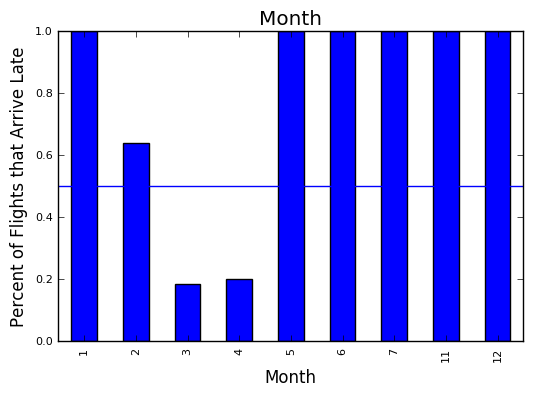

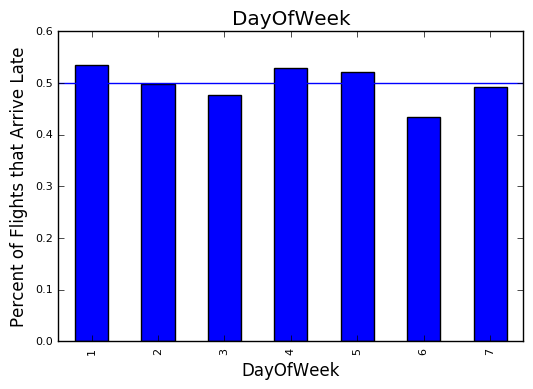

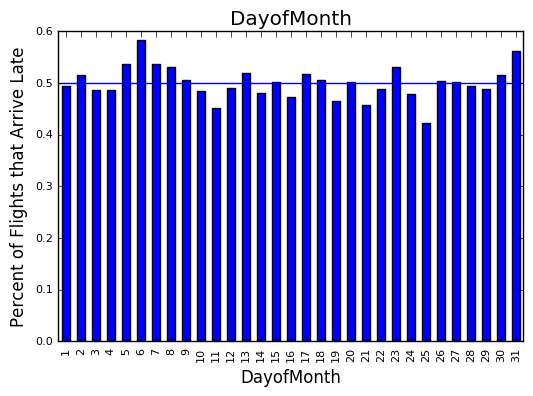

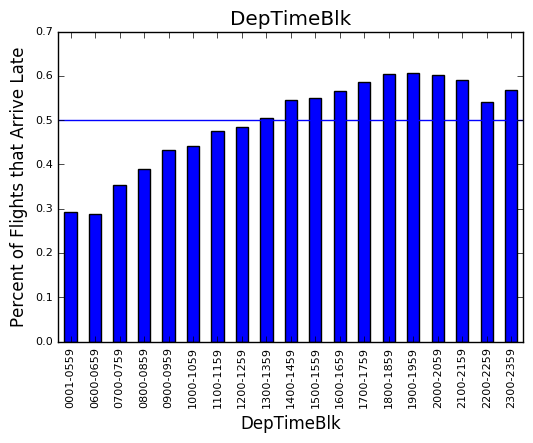

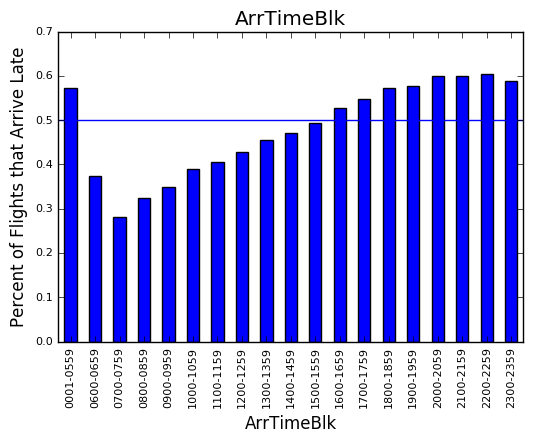

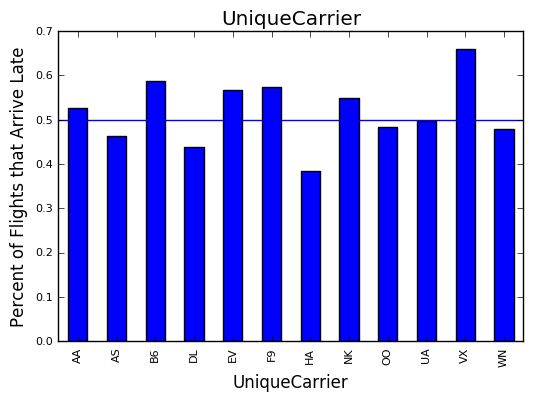

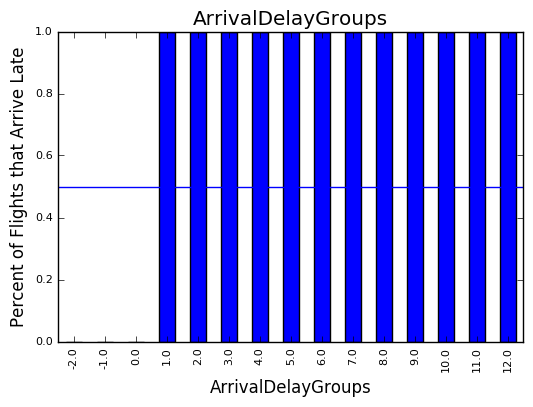

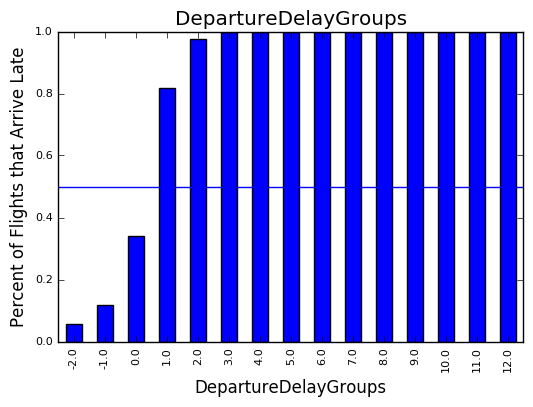

In [11]:
# Proportion of late flights per category based on all other flights

avgLate = np.sum(data['ArrDel15'])/len(data['ArrDel15'])
attributes = ['Month','DayOfWeek', 'DayofMonth', 'DepTimeBlk','ArrTimeBlk','UniqueCarrier',
             'ArrivalDelayGroups','DepartureDelayGroups']
for i,pred in enumerate(attributes):
    plt.figure(i, figsize=(15, 5))
    group = data.groupby([pred], as_index=False).aggregate(np.mean)[[pred, 'ArrDel15']]
    group.sort_values(by=pred, inplace=True)    
    group.plot.bar(x=pred, y='ArrDel15')
    plt.axhline(y=avgLate, label='Average')
    plt.ylabel('Percent of Flights that Arrive Late')
    plt.title(pred)
    plt.legend().remove()

###### Exploratory analysis reveals:

    (1) Delay changes substantially with Month e.g. lower delays in Autumn months   
    (2) Not much variation within week and day of month    
    (3) Higher delays for flights with departure and arrival time blocks from 3pm until midnight   
        (a) There seems to be a lag in the pattern for arrival time block   
        (b) Pattern starts with departure time block around 2pm and lasts until midnight    
        (c) Pattern starts with arrival time block around 4pm and lasts until 1am (with a lag of 1-2hrs)   
    (5)Similar pattern is observed for arrival and departure delay groups    

###### Label encoding:
Conversion of categorical values to numericals

In [12]:
le = LabelEncoder()

data["Unique_Carrier"] = le.fit_transform(data["UniqueCarrier"])
UniqueCarrier = list(le.classes_)
data["Carrier_Name"] = le.fit_transform(data["Carrier"])
Carrier = list(le.classes_)
data["Tail_Number"] = le.fit_transform(data["TailNum"])
TailNum = list(le.classes_)

data["Origin_Point"] = le.fit_transform(data["Origin"])
Origin = list(le.classes_)
data["Origin_CityName"] = le.fit_transform(data["OriginCityName"])
OriginCityName = list(le.classes_)
data["Origin_State"] = le.fit_transform(data["OriginState"])
OriginState = list(le.classes_)
data["OriginState_Name"] = le.fit_transform(data["OriginStateName"])
OriginStateName = list(le.classes_)

data["Destination"] = le.fit_transform(data["Dest"])
Dest = list(le.classes_)
data["Dest_CityName"] = le.fit_transform(data["DestCityName"])
DestCityName = list(le.classes_)
data["Dest_State"] = le.fit_transform(data["DestState"])
DestState = list(le.classes_)
data["Dest_StateName"] = le.fit_transform(data["DestStateName"])
DestStateName = list(le.classes_)

data["DepTime_Blk"] = le.fit_transform(data["DepTimeBlk"])
DepTimeBlk = list(le.classes_)
data["ArrTime_Blk"] = le.fit_transform(data["ArrTimeBlk"])
ArrTimeBlk = list(le.classes_)

In [13]:
data.drop(['UniqueCarrier','Carrier','TailNum',
           'Origin','OriginCityName','OriginState','OriginStateName',
          'Dest','DestCityName','DestState','DestStateName',
          'DepTimeBlk','ArrTimeBlk'], axis=1, inplace=True)#Removing original encoded columns

In [14]:
data.drop(['DepartureDelayGroups','ArrivalDelayGroups'], axis=1, inplace=True)#Removing delay details as per the task

In [15]:
print('Dimension reduced to:')
print(len(data.columns))
data.describe()

Dimension reduced to:
48


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,...,Origin_Point,Origin_CityName,Origin_State,OriginState_Name,Destination,Dest_CityName,Dest_State,Dest_StateName,DepTime_Blk,ArrTime_Blk
count,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,...,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06
mean,2.016716e+03,1.849681e+00,4.556488e+00,1.585441e+01,3.983558e+00,2.016763e+07,1.988975e+04,2.125698e+03,1.270613e+04,1.270616e+06,...,1.577828e+02,1.512563e+02,2.052470e+01,2.035186e+01,1.591979e+02,1.535284e+02,2.049524e+01,2.031854e+01,8.609646e+00,1.022948e+01
std,4.511033e-01,9.402156e-01,2.779950e+00,8.767598e+00,1.979431e+00,4.289726e+03,3.929491e+02,1.730777e+03,1.523025e+03,1.523022e+05,...,8.572949e+01,8.880323e+01,1.534332e+01,1.531394e+01,8.573690e+01,8.861223e+01,1.537263e+01,1.534030e+01,4.784717e+00,4.969031e+00
min,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.016050e+07,1.939300e+04,1.000000e+00,1.013500e+04,1.013503e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,2.016122e+07,1.939300e+04,7.280000e+02,1.129200e+04,1.129202e+06,...,8.000000e+01,7.100000e+01,7.000000e+00,7.000000e+00,8.000000e+01,7.100000e+01,7.000000e+00,7.000000e+00,5.000000e+00,6.000000e+00
50%,2.017000e+03,2.000000e+00,4.000000e+00,1.600000e+01,4.000000e+00,2.017031e+07,1.980500e+04,1.648000e+03,1.289200e+04,1.289204e+06,...,1.700000e+02,1.650000e+02,1.700000e+01,1.800000e+01,1.700000e+02,1.740000e+02,1.700000e+01,1.800000e+01,9.000000e+00,1.100000e+01
75%,2.017000e+03,2.000000e+00,5.000000e+00,2.300000e+01,6.000000e+00,2.017040e+07,2.030400e+04,3.035000e+03,1.405700e+04,1.405702e+06,...,2.300000e+02,2.310000e+02,3.300000e+01,3.300000e+01,2.300000e+02,2.310000e+02,3.300000e+01,3.300000e+01,1.300000e+01,1.400000e+01
max,2.017000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.017043e+07,2.117100e+04,7.439000e+03,1.621800e+04,1.621801e+06,...,3.130000e+02,3.090000e+02,5.100000e+01,5.100000e+01,3.130000e+02,3.090000e+02,5.100000e+01,5.100000e+01,1.800000e+01,1.800000e+01


All variables are now numeric. But above statistics makes sense only for originally numeric variables. For e.g. central tendency measures for Year, Airline ID etc. do not make much sense.

# Machine Learning Modeling

### Random Forest is chosen for Machine Learning due to following reasons:
(1) Large data size   
(2) Categorical nature of many variables   
(3) Non-linearity of dataset (LinearRegression was attempted but had high MSE; Linear relation doesn't exist for many variables)  
(4) Underlying complex dependencies between variables

## PART 2: Model creation with original raw data

### Feature Selection to remove redundant variables

###### Creation of data subset:
Predictor and target variable columns along with some basic statistics

In [16]:
#Data set up as predictors and target
rfDataOriginal = pd.DataFrame(data)
Delay_YesNo = rfDataOriginal['ArrDel15']
rfDataOriginal.drop(['ArrDel15'], axis=1, inplace=True)#Removing target variable
print('Dimension reduced to:')
print(len(rfDataOriginal.columns))
data.describe()

Dimension reduced to:
47


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,...,Origin_Point,Origin_CityName,Origin_State,OriginState_Name,Destination,Dest_CityName,Dest_State,Dest_StateName,DepTime_Blk,ArrTime_Blk
count,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,...,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06
mean,2.016716e+03,1.849681e+00,4.556488e+00,1.585441e+01,3.983558e+00,2.016763e+07,1.988975e+04,2.125698e+03,1.270613e+04,1.270616e+06,...,1.577828e+02,1.512563e+02,2.052470e+01,2.035186e+01,1.591979e+02,1.535284e+02,2.049524e+01,2.031854e+01,8.609646e+00,1.022948e+01
std,4.511033e-01,9.402156e-01,2.779950e+00,8.767598e+00,1.979431e+00,4.289726e+03,3.929491e+02,1.730777e+03,1.523025e+03,1.523022e+05,...,8.572949e+01,8.880323e+01,1.534332e+01,1.531394e+01,8.573690e+01,8.861223e+01,1.537263e+01,1.534030e+01,4.784717e+00,4.969031e+00
min,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.016050e+07,1.939300e+04,1.000000e+00,1.013500e+04,1.013503e+06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,2.016122e+07,1.939300e+04,7.280000e+02,1.129200e+04,1.129202e+06,...,8.000000e+01,7.100000e+01,7.000000e+00,7.000000e+00,8.000000e+01,7.100000e+01,7.000000e+00,7.000000e+00,5.000000e+00,6.000000e+00
50%,2.017000e+03,2.000000e+00,4.000000e+00,1.600000e+01,4.000000e+00,2.017031e+07,1.980500e+04,1.648000e+03,1.289200e+04,1.289204e+06,...,1.700000e+02,1.650000e+02,1.700000e+01,1.800000e+01,1.700000e+02,1.740000e+02,1.700000e+01,1.800000e+01,9.000000e+00,1.100000e+01
75%,2.017000e+03,2.000000e+00,5.000000e+00,2.300000e+01,6.000000e+00,2.017040e+07,2.030400e+04,3.035000e+03,1.405700e+04,1.405702e+06,...,2.300000e+02,2.310000e+02,3.300000e+01,3.300000e+01,2.300000e+02,2.310000e+02,3.300000e+01,3.300000e+01,1.300000e+01,1.400000e+01
max,2.017000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.017043e+07,2.117100e+04,7.439000e+03,1.621800e+04,1.621801e+06,...,3.130000e+02,3.090000e+02,5.100000e+01,5.100000e+01,3.130000e+02,3.090000e+02,5.100000e+01,5.100000e+01,1.800000e+01,1.800000e+01


###### Check for multi-collinearity of variables

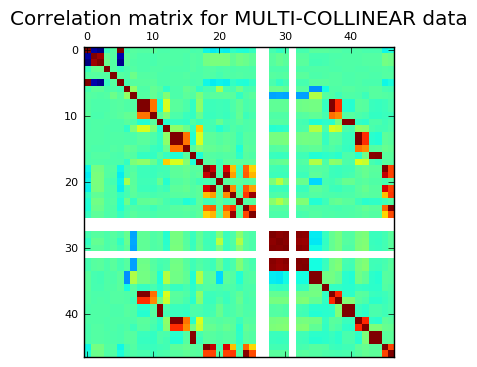

In [17]:
plt.matshow(rfDataOriginal.corr())
plt.title('Correlation matrix for MULTI-COLLINEAR data')
corr = rfDataOriginal.corr()
#corr

Note: Darker cells indicate high collinearity

In [18]:
corr = rfDataOriginal.corr()#Lists all pairs of highly collinear variables
indices = np.where(corr > 0.8)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('Year', 'FlightDate'),
 ('Quarter', 'Month'),
 ('OriginAirportID', 'OriginAirportSeqID'),
 ('OriginAirportID', 'Origin_Point'),
 ('OriginAirportSeqID', 'Origin_Point'),
 ('OriginStateFips', 'Origin_State'),
 ('OriginStateFips', 'OriginState_Name'),
 ('DestAirportID', 'DestAirportSeqID'),
 ('DestAirportID', 'Destination'),
 ('DestAirportSeqID', 'Destination'),
 ('DestStateFips', 'Dest_State'),
 ('DestStateFips', 'Dest_StateName'),
 ('CRSDepTime', 'DepTime'),
 ('CRSDepTime', 'WheelsOff'),
 ('CRSDepTime', 'DepTime_Blk'),
 ('DepTime', 'WheelsOff'),
 ('DepTime', 'DepTime_Blk'),
 ('WheelsOff', 'DepTime_Blk'),
 ('WheelsOn', 'ArrTime'),
 ('CRSArrTime', 'ArrTime_Blk'),
 ('CRSElapsedTime', 'ActualElapsedTime'),
 ('CRSElapsedTime', 'AirTime'),
 ('CRSElapsedTime', 'Distance'),
 ('CRSElapsedTime', 'DistanceGroup'),
 ('ActualElapsedTime', 'AirTime'),
 ('ActualElapsedTime', 'Distance'),
 ('ActualElapsedTime', 'DistanceGroup'),
 ('AirTime', 'Distance'),
 ('AirTime', 'DistanceGroup'),
 ('Distance', '

###### Removal of only redundant columns
Note: Collinearity is not the main consideration here(Part 3 deals with it)

In [19]:
#Subsetting to remove redundant variables using results from above cell for quick filtering
rfDataOriginal.drop(['OriginAirportSeqID','OriginCityMarketID', 'OriginStateFips', 'OriginWac', 
                     'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac',
                     'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime','Carrier_Name', 
                     'Origin_Point', 'Origin_CityName', 'Origin_State', 'OriginState_Name', 
                     'Destination', 'Dest_CityName', 'Dest_State', 'Dest_StateName'], axis=1, inplace=True)

In [20]:
print('Dimension finally reduced to:')
print(len(rfDataOriginal.columns))
list(rfDataOriginal.columns)

Dimension finally reduced to:
27


['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'AirlineID',
 'FlightNum',
 'OriginAirportID',
 'DestAirportID',
 'DepTime',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'ArrTime',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'DistanceGroup',
 'Unique_Carrier',
 'Tail_Number',
 'DepTime_Blk',
 'ArrTime_Blk']

### Model building with non-redundant variables

###### Train/test split
- Train:Test split = 80:20

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(rfDataOriginal, Delay_YesNo, test_size=0.2, random_state=42)

###### Grid search
Grid search is not performed for all the desired parameter combinations and values due to computational time

In [22]:
startTimeGS = datetime.now()
from sklearn.grid_search import GridSearchCV
rf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [10, 25],
#                 'min_samples_split': [2, 4],
#                 'min_samples_leaf': [2, 4],
#                 'max_features': ['sqrt', 'log2'],
                 "criterion" : ["gini", "entropy"]
             }
grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(X_train, Y_train)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.grid_scores_
print('Random forest Grid Search with non-redundant variables took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with non-redundant variables took [ 1:20:38.521561 ] seconds.


###### Best model, corresponding parameters and CV results
Used for model selection in next step

In [23]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
{'n_estimators': 25, 'criterion': 'entropy'}


[mean: 0.95709, std: 0.00073, params: {'n_estimators': 10, 'criterion': 'gini'},
 mean: 0.96161, std: 0.00075, params: {'n_estimators': 25, 'criterion': 'gini'},
 mean: 0.95691, std: 0.00101, params: {'n_estimators': 10, 'criterion': 'entropy'},
 mean: 0.96202, std: 0.00054, params: {'n_estimators': 25, 'criterion': 'entropy'}]

###### Model selection
- Best model and parameters from above are used to train the final model on entire training set
- 10-fold Cross validation is performed to find the overall error

In [24]:
startTimeRF = datetime.now()
rf = RandomForestClassifier(n_estimators = bestParameters.get('n_estimators'), 
#                            min_samples_split=bestParameters.get('min_samples_split'),
#                           min_samples_leaf = bestParameters.get('min_samples_leaf'),
#                           max_features = bestParameters.get('max_features'),
                           criterion = bestParameters.get('criterion'))
cv = cross_validation.KFold(len(X_train), n_folds=10, shuffle=True, random_state=2)
cvScores = cross_val_score(rf, X_train, Y_train, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))
rf.fit(X_train, Y_train)
print('Random forest training and testing with with non-redundant variables took [', 
      datetime.now() - startTimeRF, '] seconds.')

Mean cross validation score is: 0.962069041124
Random forest training and testing with with non-redundant variables took [ 0:31:59.416214 ] seconds.


###### Performance evaluation
- Prediction is done on the hold out test set to evaluate performance
- Confusion matrix, Accuracy and Recall are computed
- ROC curve is also plotted to pictorically depict 'Area under curve (AUC)' as 'Accuracy' 

Accuracy: 96.27%
Recall: 94.0%
Confusion matrix:
[[156043   2277]
 [  9573 149975]]
Area under the ROC curve: 0.0371915079472


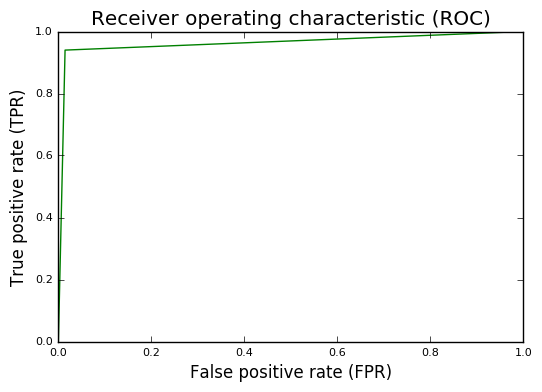

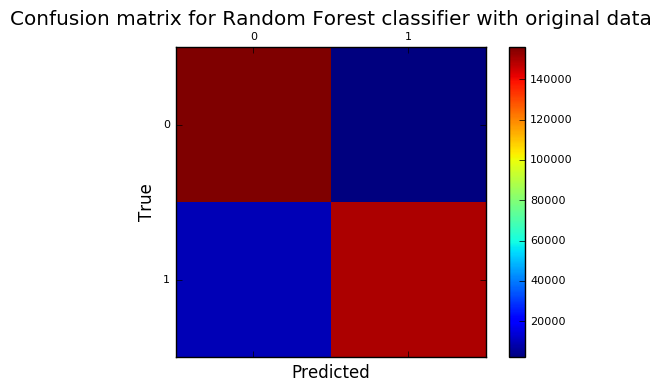

In [25]:
Y_rf_pred = rf.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, Y_rf_pred,labels)

print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(Y_test, Y_rf_pred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

fig = plt.figure(2)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with original data')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Inferences:
- High accuracy was obtained when model was first created.
- This prompted cross validation with 10-fold in order to be convinced that it wasnt a chance performance
- Accuracy improved when more data was added. More data is always better than any sophisticated model!
- Inferences from exploratory analysis was critical in doing feature selection and obtaining good performance
- E.g. Certain features (DepTimeBlk, Month etc.) with substantial variation were added to improve performance
- Handling of class imbalance improved Accuracy and Recall respectively by more than 10% and 15%

## PART 3: Model creation with PCA components

### Feature Engineering by removing multi-collinear variables

###### Removal of redundant and highly collinear variables from dataset
Highly collinear variables are removed before PCA as they amplify their correlation through the common underlying factor and distort PCA results

In [26]:
rfDataPCA = pd.DataFrame(data)
#Subsetting based on earlier feature selection of variables (derived from correlation)
rfDataPCA.drop(['OriginAirportSeqID','OriginCityMarketID', 'OriginStateFips', 'OriginWac', 
                     'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac',
                     'CRSDepTime', 'CRSElapsedTime', 'CRSArrTime','Carrier_Name', 
                     'Origin_Point', 'Origin_CityName', 'Origin_State', 'OriginState_Name', 
                     'Destination', 'Dest_CityName', 'Dest_State', 'Dest_StateName'], axis=1, inplace=True)
print('Dimension reduced to:')
print(len(rfDataPCA.columns))
list(rfDataPCA.columns)
rfDataPCA.describe()

Dimension reduced to:
28


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,AirlineID,FlightNum,OriginAirportID,DestAirportID,...,Diverted,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,Unique_Carrier,Tail_Number,DepTime_Blk,ArrTime_Blk
count,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,...,1589336.0,1.589336e+06,1.589336e+06,1589336.0,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06
mean,2.016716e+03,1.849681e+00,4.556488e+00,1.585441e+01,3.983558e+00,2.016763e+07,1.988975e+04,2.125698e+03,1.270613e+04,1.273135e+04,...,0.0,1.465977e+02,1.203909e+02,1.0,8.652024e+02,3.930325e+00,5.976681e+00,2.633907e+03,8.609646e+00,1.022948e+01
std,4.511033e-01,9.402156e-01,2.779950e+00,8.767598e+00,1.979431e+00,4.289726e+03,3.929491e+02,1.730777e+03,1.523025e+03,1.523896e+03,...,0.0,7.901650e+01,7.595698e+01,0.0,6.224418e+02,2.447818e+00,4.135267e+00,1.449892e+03,4.784717e+00,4.969031e+00
min,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.016050e+07,1.939300e+04,1.000000e+00,1.013500e+04,1.013500e+04,...,0.0,1.500000e+01,7.000000e+00,1.0,3.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,2.016122e+07,1.939300e+04,7.280000e+02,1.129200e+04,1.129200e+04,...,0.0,8.700000e+01,6.300000e+01,1.0,3.970000e+02,2.000000e+00,3.000000e+00,1.444000e+03,5.000000e+00,6.000000e+00
50%,2.017000e+03,2.000000e+00,4.000000e+00,1.600000e+01,4.000000e+00,2.017031e+07,1.980500e+04,1.648000e+03,1.289200e+04,1.289200e+04,...,0.0,1.280000e+02,1.020000e+02,1.0,6.960000e+02,3.000000e+00,7.000000e+00,2.621000e+03,9.000000e+00,1.100000e+01
75%,2.017000e+03,2.000000e+00,5.000000e+00,2.300000e+01,6.000000e+00,2.017040e+07,2.030400e+04,3.035000e+03,1.405700e+04,1.405700e+04,...,0.0,1.810000e+02,1.520000e+02,1.0,1.107000e+03,5.000000e+00,1.100000e+01,3.932000e+03,1.300000e+01,1.400000e+01
max,2.017000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.017043e+07,2.117100e+04,7.439000e+03,1.621800e+04,1.621800e+04,...,0.0,7.840000e+02,7.230000e+02,1.0,4.983000e+03,1.100000e+01,1.100000e+01,5.057000e+03,1.800000e+01,1.800000e+01


In [27]:
indices = np.where(corr > 0.7)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('Year', 'FlightDate'),
 ('Quarter', 'Month'),
 ('OriginAirportID', 'OriginAirportSeqID'),
 ('OriginAirportID', 'Origin_Point'),
 ('OriginAirportID', 'Origin_CityName'),
 ('OriginAirportSeqID', 'Origin_Point'),
 ('OriginAirportSeqID', 'Origin_CityName'),
 ('OriginStateFips', 'Origin_State'),
 ('OriginStateFips', 'OriginState_Name'),
 ('DestAirportID', 'DestAirportSeqID'),
 ('DestAirportID', 'Destination'),
 ('DestAirportID', 'Dest_CityName'),
 ('DestAirportSeqID', 'Destination'),
 ('DestAirportSeqID', 'Dest_CityName'),
 ('DestStateFips', 'Dest_State'),
 ('DestStateFips', 'Dest_StateName'),
 ('CRSDepTime', 'DepTime'),
 ('CRSDepTime', 'WheelsOff'),
 ('CRSDepTime', 'DepTime_Blk'),
 ('CRSDepTime', 'ArrTime_Blk'),
 ('DepTime', 'WheelsOff'),
 ('DepTime', 'DepTime_Blk'),
 ('DepTime', 'ArrTime_Blk'),
 ('WheelsOff', 'DepTime_Blk'),
 ('WheelsOff', 'ArrTime_Blk'),
 ('WheelsOn', 'CRSArrTime'),
 ('WheelsOn', 'ArrTime'),
 ('WheelsOn', 'ArrTime_Blk'),
 ('CRSArrTime', 'ArrTime'),
 ('CRSArrTime', 'Arr

In [28]:
rfDataPCA.drop(['FlightDate','DepTime','DepTime_Blk','ActualElapsedTime','AirTime','DistanceGroup','DepTime_Blk'], 
          axis=1, inplace=True)#Further reduction of multicollinearity for PCA

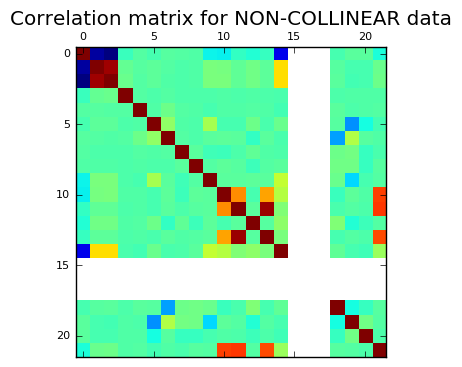

In [29]:
#Check for collinearity
plt.matshow(rfDataPCA.corr())
plt.title('Correlation matrix for NON-COLLINEAR data')
corr = rfDataPCA.corr()

Note: Darker cells indicate high collinearity. It is seen here only between the variable and itself.

In [30]:
indices = np.where(corr > 0.7)
indices = [(corr.columns[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('Quarter', 'Month'),
 ('WheelsOff', 'ArrTime_Blk'),
 ('WheelsOn', 'ArrTime'),
 ('WheelsOn', 'ArrTime_Blk')]

###### Data ready for PCA

In [31]:
print('Dimension reduced to:')
print(len(rfDataPCA.columns))
rfDataPCA.describe()

Dimension reduced to:
22


,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,DestAirportID,TaxiOut,...,TaxiIn,ArrTime,ArrDel15,Cancelled,Diverted,Flights,Distance,Unique_Carrier,Tail_Number,ArrTime_Blk
count,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06,...,1.589336e+06,1.589336e+06,1589336.0,1589336.0,1589336.0,1589336.0,1.589336e+06,1.589336e+06,1.589336e+06,1.589336e+06
mean,2.016716e+03,1.849681e+00,4.556488e+00,1.585441e+01,3.983558e+00,1.988975e+04,2.125698e+03,1.270613e+04,1.273135e+04,1.813505e+01,...,8.071743e+00,1.506145e+03,0.5,0.0,0.0,1.0,8.652024e+02,5.976681e+00,2.633907e+03,1.022948e+01
std,4.511033e-01,9.402156e-01,2.779950e+00,8.767598e+00,1.979431e+00,3.929491e+02,1.730777e+03,1.523025e+03,1.523896e+03,1.191527e+01,...,7.438466e+00,5.786371e+02,0.5,0.0,0.0,0.0,6.224418e+02,4.135267e+00,1.449892e+03,4.969031e+00
min,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.939300e+04,1.000000e+00,1.013500e+04,1.013500e+04,1.000000e+00,...,1.000000e+00,1.000000e+00,0.0,0.0,0.0,1.0,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.016000e+03,1.000000e+00,3.000000e+00,8.000000e+00,2.000000e+00,1.939300e+04,7.280000e+02,1.129200e+04,1.129200e+04,1.100000e+01,...,4.000000e+00,1.120000e+03,0.0,0.0,0.0,1.0,3.970000e+02,3.000000e+00,1.444000e+03,6.000000e+00
50%,2.017000e+03,2.000000e+00,4.000000e+00,1.600000e+01,4.000000e+00,1.980500e+04,1.648000e+03,1.289200e+04,1.289200e+04,1.500000e+01,...,6.000000e+00,1.603000e+03,0.5,0.0,0.0,1.0,6.960000e+02,7.000000e+00,2.621000e+03,1.100000e+01
75%,2.017000e+03,2.000000e+00,5.000000e+00,2.300000e+01,6.000000e+00,2.030400e+04,3.035000e+03,1.405700e+04,1.405700e+04,2.100000e+01,...,9.000000e+00,1.959000e+03,1.0,0.0,0.0,1.0,1.107000e+03,1.100000e+01,3.932000e+03,1.400000e+01
max,2.017000e+03,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.117100e+04,7.439000e+03,1.621800e+04,1.621800e+04,1.830000e+02,...,4.130000e+02,2.400000e+03,1.0,0.0,0.0,1.0,4.983000e+03,1.100000e+01,5.057000e+03,1.800000e+01


### Dimension reduction with PCA

PCA is done on three variants of the dataset to identify which one needs to be used for modeling:
- PCA 1: Dataset with Multi-Collinear variables: Highly collinear variables have amplified contribution in PCA
- PCA 2: Dataset with Redundant variables removed (i.e. repeated ID, dep time, arr time etc.)
- PCA 3: Dataset without any Non-Collinear variables

This was a last minute approach to demonstrate that my initial hypothesis was wrong. My initial thought was that PCA would be better with non-collinear variables and this would give better model performance.

However, I saw better model performance (> 10% for accuracy and recall) with PCs derived from multi-collinear dataset. This was because the first two components could almost fully explain the variance in target variable. But in the second and third cases,around 8PCs were needed to fully explain the variance while the scree plot was giving an intuition of choosing 3 or 4 components.

Due to limitation in training time, results are demonstrated only for model creation with PCs derived from multi-collinear data.

###### PCA 1: On HIGHLY MULTI-COLLINEAR data

In [32]:
pca = PCA(n_components=8)
data_reduced = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[  5.10437477e-01   4.88965331e-01   3.96674386e-04   6.56055689e-05
   4.50305685e-05   2.62220344e-05   2.24592784e-05   2.01350522e-05]


array([ 51.04,  99.94,  99.98,  99.99,  99.99,  99.99,  99.99,  99.99])

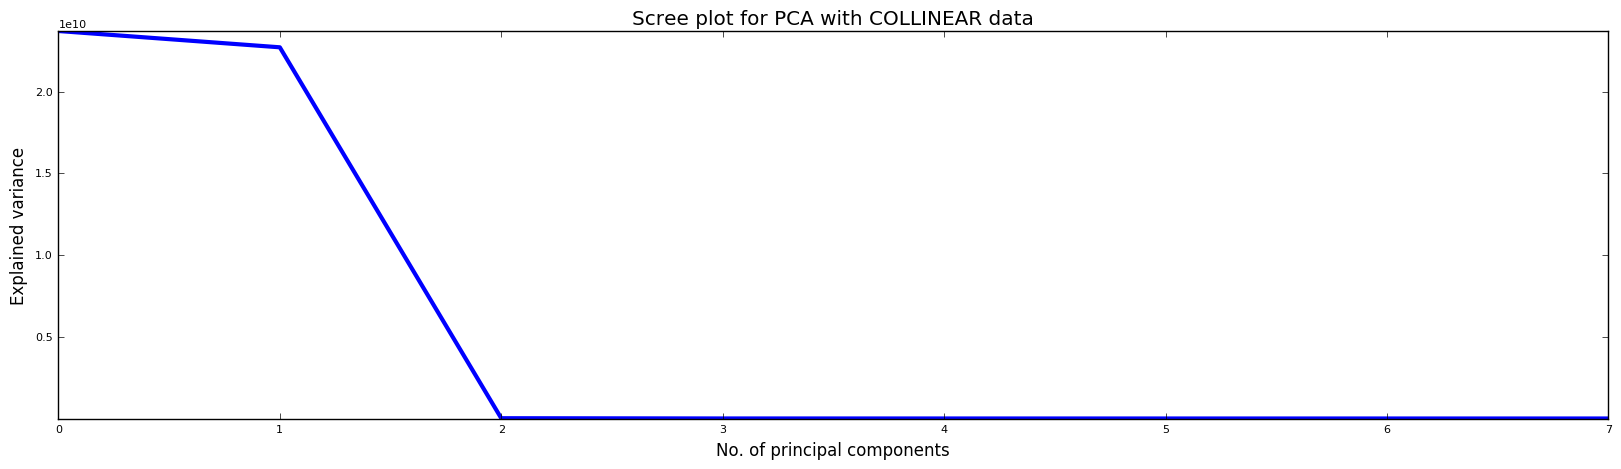

In [33]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with COLLINEAR data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

Note: Elbow is used to choose the number of principal components (Here, #PCs chosen = 2)

###### PCA 2: On PARTIALLY MULTI-COLLINEAR data

In [34]:
pca = PCA(n_components=8)
rfDataOriginal_reduced = pca.fit_transform(rfDataOriginal)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[ 0.61641751  0.10176803  0.0821394   0.07602882  0.06768832  0.02958812
  0.01189005  0.00863503]


array([ 61.64,  71.82,  80.03,  87.63,  94.4 ,  97.36,  98.55,  99.41])

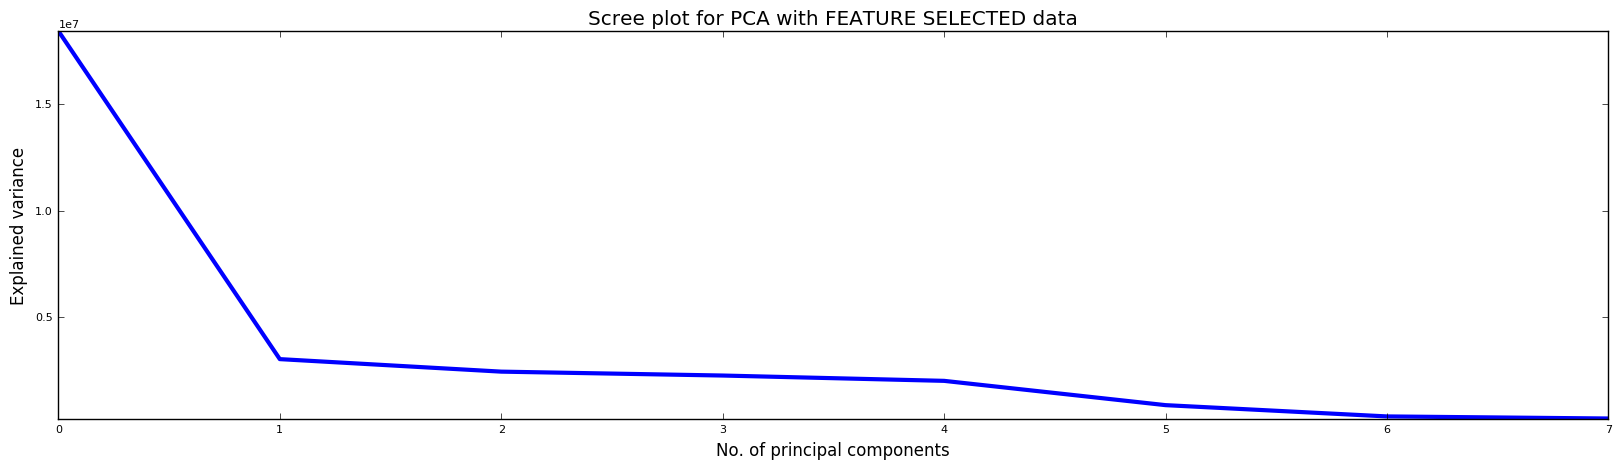

In [35]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with FEATURE SELECTED data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

Note: Elbow is used to choose the number of principal components (Here, #PCs chosen = 4)

###### PCA 3: On LOW MULTI-COLLINEAR data

In [36]:
pca = PCA(n_components=8)
rfDataPCA_reduced = pca.fit_transform(rfDataPCA)
print(pca.explained_variance_ratio_)
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[ 0.27129582  0.21898846  0.20263852  0.18061511  0.06696999  0.03077711
  0.01416097  0.01316053]


array([ 27.13,  49.03,  69.29,  87.35,  94.05,  97.13,  98.55,  99.87])

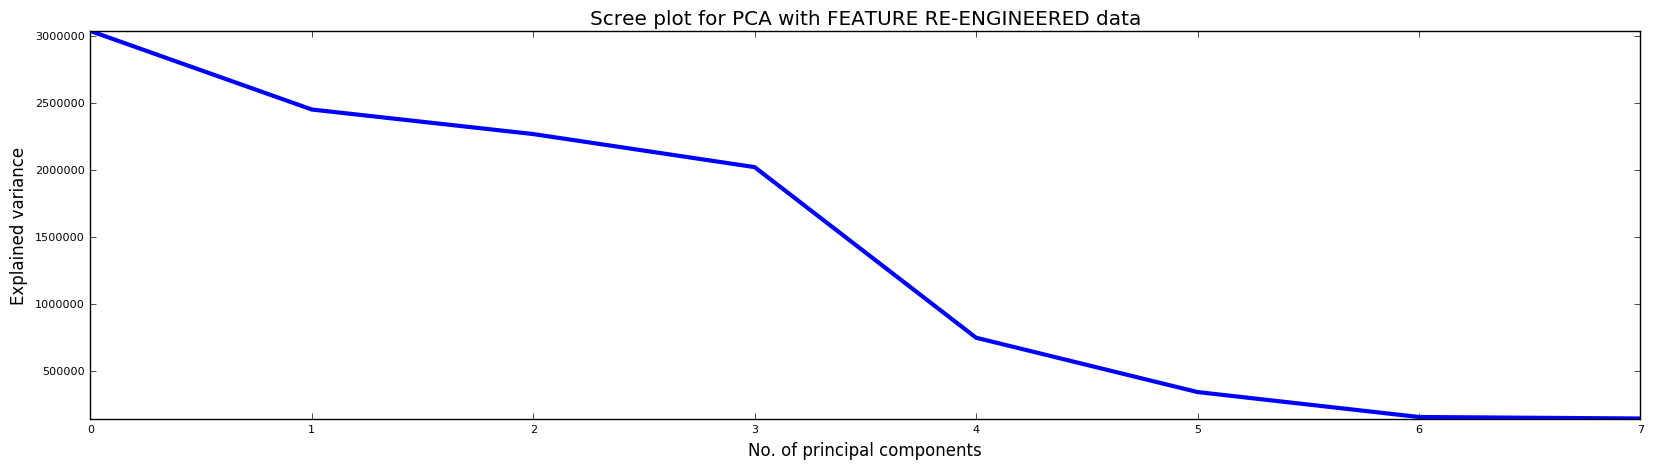

In [37]:
plt.figure(1, figsize=(20, 5))
plt.plot(pca.explained_variance_, linewidth=3)
plt.axis('tight')
plt.title('Scree plot for PCA with FEATURE RE-ENGINEERED data')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')

Note: Elbow is used to choose the number of principal components (Here, #PCs chosen = 4)

In [38]:
Delay_YesNo = data['ArrDel15']
data.drop(['ArrDel15'], axis=1, inplace=True)#Removing target variable
print('Dimension reduced to:')
print(len(data.columns))
data.describe()
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print('Cumulative explained variance:')
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

Dimension reduced to:
47
[ 0.51043748  0.48896533]
Cumulative explained variance:


array([ 51.04,  99.94])

### Model building with dimension reduced data

###### Train/test split
Train:Test split = 80:20

In [39]:
x_train, x_test, y_train, y_test = train_test_split(data, Delay_YesNo, test_size=0.2, random_state=42)

###### Grid search
Grid search is not performed for all the desired parameter combinations and values due to computational time

In [40]:
startTimeGS = datetime.now()
from sklearn.grid_search import GridSearchCV
rf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [10, 25],
#                 'min_samples_split': [2, 4],
#                 'min_samples_leaf': [2, 4],
#                 'max_features': [sqrt', 'log2'],
                 "criterion" : ["gini", "entropy"]
             }
grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(x_train, y_train)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.grid_scores_
print('Random forest Grid Search with dimension reduced data took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search with dimension reduced data took [ 1:42:32.520642 ] seconds.


In [41]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
{'n_estimators': 25, 'criterion': 'gini'}


[mean: 0.96794, std: 0.00106, params: {'n_estimators': 10, 'criterion': 'gini'},
 mean: 0.97418, std: 0.00112, params: {'n_estimators': 25, 'criterion': 'gini'},
 mean: 0.96757, std: 0.00062, params: {'n_estimators': 10, 'criterion': 'entropy'},
 mean: 0.97369, std: 0.00087, params: {'n_estimators': 25, 'criterion': 'entropy'}]

###### Model selection
- Best model and parameters from above are used to train the final model on entire training set
- 10- fold Cross validation is performed to find the overall error

In [42]:
startTimeRF = datetime.now()
rf = RandomForestClassifier(n_estimators = bestParameters.get('n_estimators'), 
#                            min_samples_split=bestParameters.get('min_samples_split'),
#                           min_samples_leaf = bestParameters.get('min_samples_leaf'),
#                           max_features = bestParameters.get('max_features'),
                           criterion = bestParameters.get('criterion'))
cv = cross_validation.KFold(len(x_train), n_folds=10, shuffle=True, random_state=2)
cvScores = cross_val_score(rf, x_train, y_train, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))
rf.fit(x_train, y_train)
print('Random forest training and testing with PCs took [', datetime.now() - startTimeRF, '] seconds.')

Mean cross validation score is: 0.974501126167
Random forest training and testing with PCs took [ 0:37:48.068291 ] seconds.


###### Performance evaluation
- Prediction is done on the hold out test set to evaluate performance
- Confusion matrix, Accuracy and Recall are computed
- ROC curve is also plotted to pictorically depict 'Area under curve (AUC)' as 'Accuracy' 

Accuracy: 97.5%
Recall: 95.95%
Confusion matrix:
[[156839   1481]
 [  6455 153093]]
Area under the ROC curve: 0.0249062579649


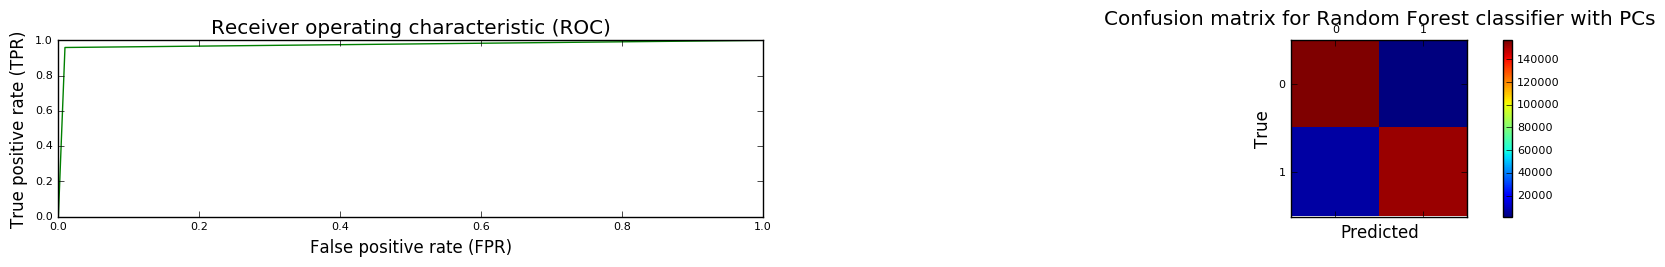

In [43]:
y_rf_pred = rf.predict(x_test)

labels = [0, 1]
cm = confusion_matrix(y_test, y_rf_pred,labels)

print('Accuracy: ' + str(np.round(100*float(cm[0][0]+cm[1][1])/float((cm[0][0]+cm[1][1] + cm[1][0] + cm[0][1])),2))+'%')
print('Recall: ' + str(np.round(100*float((cm[1][1]))/float((cm[1][0]+cm[1][1])),2))+'%')
print('Confusion matrix:')
print(cm)

fpr, tpr, _ = roc_curve(y_test, y_rf_pred)
auc = np.trapz(fpr,tpr)
print('Area under the ROC curve: ' + str(auc))

fig = plt.figure(figsize=(20, 5))

plt.subplot2grid((2, 2), (1, 0), colspan=1)
#plt.subplot(1,2,1)
plt.plot(fpr,tpr,color='green')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('Receiver operating characteristic (ROC)')

ax1 = plt.subplot2grid((2, 2), (1, 1))
#ax = fig.add_subplot(122)
cax = ax1.matshow(cm)
plt.title('Confusion matrix for Random Forest classifier with PCs')
fig.colorbar(cax)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Inferences:
- Random forest on PCs always demonstrated slightly better performance, but this was marginal (1-2%).
- It is inferred that dimension reduction with PCA is not really required for Random forest as it is already a modeling method that inherently handles variance in data through bagging, random splitting and voting.
- It may however be a delightful approach if one wants to reduce dimension by avoiding the hassle of removing collinear variables. A PCA can capture all the variation easily and be fed straight to random forest thus enabling quicker modeling. 
    

### Future Work:
- As performance was observed to be improving with more data, it is strongly suggested to train on more data which is easily available from DOT website.
- This will improve Recall and give better prediction for 'Delayed' flights which is the problem in hand.
- It is also recommended that an initial coarser search followed by finer grid search can help in identifying optimal model parameters that can enable prediction with higher performance.
- Sampling of data to avoid class imbalance resulted in discarding a lot of data. I am not much concerned about this due to availability of huge amounts of data in DOT website. But, this may need to be addressed elsewhere by exploring imputation. In this problem, regression imputation is suggested as mean and zero imputation did not provide good results.
- Feature transformation could have been explored by deriving new features from existing data. Examples can be Airport delay, Airline delay etc from taxi duration, wheels on, wheels off etc. This would have provided much more intuitive analysis results.
- Lastly and more importantly, grid search with more trees in Random Forest is essential and is highly likely to give improved results.

### References:
- Kaggle.com
- stats.stackexchange.com
- fivethirtyeight.com

In [44]:
print('Overall execution took [', datetime.now() - startTime, '] seconds.')

Overall execution took [ 4:17:09.190782 ] seconds.
